In [ ]:
!pip install scikit-learn pandas lightgbm

In [ ]:
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import numpy as np
from pathlib import Path
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer, make_column_selector as selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, accuracy_score
from xgboost import XGBClassifier


In [ ]:
test_data = pd.read_csv('test_data.csv')
test_data.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'hosp_los',
       'adm_inhosp', 'icd9_sepsiscode', 'icd9_septicshock', 'icd10_sepsiscode',
       'icd10_septicshock', 'icd_version', 'icd9_angus', 'icd10_angus',
       'icd9_angus_over', 'icd10_angus_over', 'icd9_sepsiscode_over',
       'icd10_sepsiscode_over', 'sepsis', 'sepsistype', 'sepsistype_three',
       'anchor_age', 'age', 'gender', 'dod', 'older_adult',
       'discharge_location_factor', 'race_cate', 'race_tetra', 'race_tricho',
       'marital_dichotomous', 'insurance_dicho', 'admission_type_cate',
       'prev90d', 'prev90d_hosp', 'prev90d_hosp_sum', 'icu_hx', 'comorbidity',
       'nextadm30d', 'rehosp30d', 'nextadm7d', 'rehosp7d', 'nextadm30d_date',
       'died30d', 'died30d_noreadm', 'nextadm7d

In [ ]:
test_data['rehosp7d'].value_counts()

,count
rehosp7d,
0,7888
1,910


In [ ]:
CSV_PATH = "test_data.csv"

In [ ]:
# pip install pandas scikit-learn xgboost
# =========================
# 0) Config
# =========================
CSV_PATH = "test_data.csv"      # <-- change if needed
TARGET   = "rehosp30d"          # or 'rehosp7d', 'rehosp14d', etc.

# =========================
# 1) Load
# =========================
df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# =========================
# 2) Minimal cleaning + datetime features
# =========================
datetime_cols = [
    "admittime","dischtime","deathtime","edregtime","edouttime",
    "nextadm30d_date","nextadm7d_date"
]
for c in datetime_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]   = s.dt.year
    out[f"{prefix}_month"]  = s.dt.month
    out[f"{prefix}_dow"]    = s.dt.dayofweek
    out[f"{prefix}_hour"]   = s.dt.hour
    return out

# engineer a few timing features if available
extra_feats = []
if "admittime" in df.columns:
    extra_feats.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra_feats.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds() / 3600.0
    extra_feats.append(pd.DataFrame({"ed_len_hours": ed_len_hours}))

if extra_feats:
    extra = pd.concat(extra_feats, axis=1)
    df = pd.concat([df, extra], axis=1)

# =========================
# 3) Build feature list automatically (include “everything” but avoid leakage)
# =========================
all_cols = df.columns.tolist()

# ID-like columns (no predictive signal)
id_cols = {"subject_id", "hadm_id", "admit_provider_id"}

# raw datetime columns (we already extracted features above)
raw_dt_cols = set([c for c in datetime_cols if c in df.columns])

# leakage columns (future info relative to prediction at discharge)
# Keep ONLY the chosen TARGET; drop any other rehosp/nextadm/died variants & their dates
def is_leak(col: str) -> bool:
    # note: keep TARGET itself out of features anyway
    if col == TARGET:
        return True
    lc = col.lower()
    # anything about future admissions/rehosp windows or death after discharge
    leak_prefixes = ("rehosp", "nextadm", "died")
    return lc.startswith(leak_prefixes)

leak_cols = {c for c in all_cols if is_leak(c)}

# Build candidate features set:
drop_cols = id_cols | raw_dt_cols | leak_cols | {TARGET}
feature_cols = [c for c in all_cols if c not in drop_cols]

# Sanity: some helpful booleans may still be there, that’s fine (treated as numeric 0/1)
print(f"Using {len(feature_cols)} features (showing first 25): {feature_cols[:25]}")

# =========================
# 4) X/y and train/test split
# =========================
X = df[feature_cols].copy()
y = df[TARGET].astype(int)

# Optional: if you prefer to drop rows missing y
mask = y.notna()
X, y = X.loc[mask], y.loc[mask]

X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# =========================
# 5) Type-aware preprocessing (auto-detect categorical vs numeric)
# =========================
cat_sel = selector(dtype_include=["object","category"])
num_sel = selector(dtype_include=[np.number, "bool"])

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_sel),
        ("num", StandardScaler(),                         num_sel),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# =========================
# 6) XGBoost pipeline + tuning
# =========================
xgb_base = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb_base)])

# Optional class imbalance handling: set scale_pos_weight
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
if pos > 0:
    spw = max(1.0, neg / pos)  # >=1
else:
    spw = 1.0

param_grid = {
    "model__n_estimators":     [300, 600, 900],
    "model__learning_rate":    [0.02, 0.05, 0.1],
    "model__max_depth":        [3, 4, 5],
    "model__min_child_weight": [1, 3, 5],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0],
    "model__reg_lambda":       [0.5, 1.0, 2.0],
    "model__scale_pos_weight": [spw]  # fixed from training split
}

search = RandomizedSearchCV(
    estimator=pipe_xgb,
    param_distributions=param_grid,
    n_iter=25,                 # bump up for more thorough search
    scoring="roc_auc",
    cv=3,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

search.fit(X_tr, y_tr)

print("\nBest CV AUC:", round(search.best_score_, 3))
print("Best params:", search.best_params_)

# =========================
# 7) Evaluate tuned model & show table
# =========================
best_xgb = search.best_estimator_
p_te = best_xgb.predict_proba(X_te)[:, 1]

auc = roc_auc_score(y_te, p_te)
acc_05 = accuracy_score(y_te, (p_te >= 0.5).astype(int))

# scan for accuracy-maximizing threshold (optional)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (p_te >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

print(f"\nTuned XGB — Test AUC: {auc:.3f}")
print(f"Tuned XGB — Accuracy @0.5: {acc_05:.3f}")
print(f"Tuned XGB — Best Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")

# compact result table (sorted by risk)
out = pd.DataFrame({
    "prob_xgb": np.round(p_te, 3),
    "true":     y_te.to_numpy()
}).sort_values("prob_xgb", ascending=False).reset_index(drop=True)

print("\nPredicted Readmission Probabilities (test set, top 20):")
print(out.head(20).to_string(index=False))

Using 50 features (showing first 25): ['admission_type', 'admission_location', 'discharge_location', 'insurance', 'language', 'marital_status', 'race', 'hospital_expire_flag', 'hosp_los', 'adm_inhosp', 'icd9_sepsiscode', 'icd9_septicshock', 'icd10_sepsiscode', 'icd10_septicshock', 'icd_version', 'icd9_angus', 'icd10_angus', 'icd9_angus_over', 'icd10_angus_over', 'icd9_sepsiscode_over', 'icd10_sepsiscode_over', 'sepsis', 'sepsistype', 'sepsistype_three', 'anchor_age']
Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best CV AUC: 0.675
Best params: {'model__subsample': 0.7, 'model__scale_pos_weight': 2.4947033898305087, 'model__reg_lambda': 1.0, 'model__n_estimators': 300, 'model__min_child_weight': 1, 'model__max_depth': 3, 'model__learning_rate': 0.02, 'model__gamma': 0.5, 'model__colsample_bytree': 0.85}

Tuned XGB — Test AUC: 0.676
Tuned XGB — Accuracy @0.5: 0.643
Tuned XGB — Best Accuracy: 0.721 at threshold 0.747

Predicted Readmission Probabilities (test set, top 20):

In [ ]:
# After fitting the pipeline
prep = best_xgb.named_steps["prep"]   # your ColumnTransformer
xgb_model = best_xgb.named_steps["model"]

# Get feature names after preprocessing
feature_names = prep.get_feature_names_out()

# Pair feature names with importance
importances = xgb_model.get_booster().get_score(importance_type="weight")

# Convert keys like 'f0', 'f1'... into real names
mapped_importances = {feature_names[int(k[1:])]: v for k, v in importances.items()}

# Sort and view top 25
sorted_feats = sorted(mapped_importances.items(), key=lambda x: x[1], reverse=True)
for feat, score in sorted_feats[:25]:
    print(f"{feat}: {score}")

hosp_los: 211.0
ed_len_hours: 185.0
prev90d_hosp_sum: 142.0
admit_year: 138.0
age: 119.0
dod_nan: 117.0
disch_hour: 104.0
anchor_age: 102.0
comorbidity: 83.0
admit_hour: 82.0
race_UNKNOWN: 66.0
prev90d_hosp: 58.0
admit_month: 46.0
admit_dow: 37.0
disch_dow: 35.0
disch_year: 33.0
sepsistype: 32.0
icu_hx: 28.0
admission_type_DIRECT EMER.: 27.0
race_BLACK/CAPE VERDEAN: 27.0
disch_month: 26.0
admission_type_SURGICAL SAME DAY ADMISSION: 19.0
admission_type_EU OBSERVATION: 15.0
gender_F: 11.0
marital_status_WIDOWED: 10.0


# 新增區段

## TARGET = rehosp30d

In [ ]:
TARGET   = "rehosp30d"       # <-- choose target
df = pd.read_csv(CSV_PATH)

# Drop rows with missing target
df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# =========================
# 2) Keep only selected features
# =========================
selected_features = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",  # categorical level
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

# Keep only those columns if they exist
available = [c for c in selected_features if c in df.columns]
X = df[available].copy()

# =========================
# 3) Preprocess
# =========================
# Treat object/category columns as categorical, rest as numeric
categorical = X.select_dtypes(include=["object","category"]).columns.tolist()
numeric     = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical),
    ("num", StandardScaler(), numeric),
])

# =========================
# 4) Model (XGBoost with reasonable defaults)
# =========================
xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_xgb_small = Pipeline([("prep", preprocess), ("model", xgb)])

# =========================
# 5) Train/test split
# =========================
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

pipe_xgb_small.fit(X_tr, y_tr)

# =========================
# 6) Evaluate
# =========================
p_te = pipe_xgb_small.predict_proba(X_te)[:, 1]

auc = roc_auc_score(y_te, p_te)
acc_05 = accuracy_score(y_te, (p_te >= 0.5).astype(int))

print(f"\nReduced XGB — Test AUC: {auc:.3f}")
print(f"Reduced XGB — Accuracy @0.5: {acc_05:.3f}")

# Sort patients by risk
out = pd.DataFrame({
    "prob_xgb_small": np.round(p_te, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_small", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (small XGB model):")
print(out.head(20).to_string(index=False))



Reduced XGB — Test AUC: 0.636
Reduced XGB — Accuracy @0.5: 0.710

Top 20 predictions (small XGB model):
 prob_xgb_small  true
          0.846     1
          0.844     1
          0.829     0
          0.822     0
          0.821     1
          0.812     1
          0.795     1
          0.768     0
          0.764     0
          0.762     1
          0.759     0
          0.757     1
          0.754     0
          0.750     1
          0.750     1
          0.741     0
          0.737     0
          0.734     0
          0.725     0
          0.725     1


In [ ]:
## TUNING
TARGET   = "rehosp30d"         # <- rehosp7d/14d/etc. if you prefer
df = pd.read_csv(CSV_PATH).copy()
df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# -----------------------------
# 2) Reduced feature set
# (Use RAW columns; OHE happens in the pipeline)
# -----------------------------
# These are the concepts you listed; use base columns that generate them:
candidate_cols = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# -----------------------------
# 3) Preprocessing
# -----------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# -----------------------------
# 4) Train/test split
# -----------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 5) XGBoost + RandomizedSearchCV (optimize ACCURACY)
# -----------------------------
# If classes are imbalanced, scale_pos_weight can help
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
spw = max(1.0, neg / max(pos, 1))

pipe = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=spw
    ))
])

param_distributions = {
    "model__n_estimators":     [200, 400, 600, 800],
    "model__learning_rate":    [0.02, 0.05, 0.1, 0.2],
    "model__max_depth":        [2, 3, 4, 5],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0, 2.0],
    "model__reg_lambda":       [0.0, 0.5, 1.0, 2.0],
    "model__reg_alpha":        [0.0, 0.1, 0.5]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=40,                 # increase for a deeper search
    scoring="accuracy",        # <-- optimize accuracy as requested
    cv=5,                      # 5-fold CV
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit best pipeline on full train split
)

search.fit(X_tr, y_tr)
best_model = search.best_estimator_
print("\nBest CV Accuracy:", round(search.best_score_, 3))
print("Best Params:", search.best_params_)

# -----------------------------
# 6) Evaluate on test
# -----------------------------
probs = best_model.predict_proba(X_te)[:, 1]

# Accuracy at default 0.5
acc_05 = accuracy_score(y_te, (probs >= 0.5).astype(int))

# Also scan thresholds to maximize test accuracy (reporting only)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

auc = roc_auc_score(y_te, probs)

print(f"\nTest Accuracy @0.5: {acc_05:.3f}")
print(f"Best Test Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")
print(f"Test AUC: {auc:.3f}")

# -----------------------------
# 7) Show a table (top 20 by risk)
# -----------------------------
out = pd.DataFrame({
    "prob_xgb_tuned": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_tuned", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions:")
print(out.head(100).to_string(index=False))

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV Accuracy: 0.655
Best Params: {'model__subsample': 1.0, 'model__reg_lambda': 2.0, 'model__reg_alpha': 0.5, 'model__n_estimators': 400, 'model__min_child_weight': 5, 'model__max_depth': 2, 'model__learning_rate': 0.1, 'model__gamma': 1.0, 'model__colsample_bytree': 0.85}

Test Accuracy @0.5: 0.636
Best Test Accuracy: 0.721 at threshold 0.775
Test AUC: 0.639

Top 20 predictions:
 prob_xgb_tuned  true
          0.882     1
          0.879     0
          0.868     1
          0.865     1
          0.864     1
          0.859     1
          0.857     0
          0.853     0
          0.849     1
          0.849     0
          0.848     0
          0.845     1
          0.843     0
          0.840     1
          0.838     1
          0.835     1
          0.834     0
          0.833     0
          0.830     1
          0.829     1
          0.828     0
          0.828     0
          0.826     0
          0.824     1


## TARGET = rehosp7d

In [ ]:
TARGET   = "rehosp7d"         # <- rehosp7d/14d/etc. if you prefer
df = pd.read_csv(CSV_PATH).copy()
df = df[df[TARGET].notna()]
y = df[TARGET].astype(int)

# -----------------------------
# 2) Reduced feature set
# (Use RAW columns; OHE happens in the pipeline)
# -----------------------------
# These are the concepts you listed; use base columns that generate them:
candidate_cols = [
    "hosp_los",
    "ed_len_hours",
    "prev90d_hosp_sum",
    "admit_year",
    "age",
    "disch_hour",
    "anchor_age",
    "comorbidity",
    "admit_hour",
    "prev90d_hosp",
    "admit_month",
    "admit_dow",
    "disch_dow",
    "disch_year",
    "sepsistype",
    "icu_hx",
    "admission_type_DIRECT EMER.",
    "race_BLACK/CAPE VERDEAN",
    "disch_month",
    "admission_type_SURGICAL SAME DAY ADMISSION"
]

available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# -----------------------------
# 3) Preprocessing
# -----------------------------
cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()
num_cols = X.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# -----------------------------
# 4) Train/test split
# -----------------------------
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

# -----------------------------
# 5) XGBoost + RandomizedSearchCV (optimize ACCURACY)
# -----------------------------
# If classes are imbalanced, scale_pos_weight can help
pos = int((y_tr == 1).sum()); neg = int((y_tr == 0).sum())
spw = max(1.0, neg / max(pos, 1))

pipe = Pipeline([
    ("prep", preprocess),
    ("model", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42,
        n_jobs=-1,
        scale_pos_weight=spw
    ))
])

param_distributions = {
    "model__n_estimators":     [200, 400, 600, 800],
    "model__learning_rate":    [0.02, 0.05, 0.1, 0.2],
    "model__max_depth":        [2, 3, 4, 5],
    "model__min_child_weight": [1, 3, 5, 7],
    "model__subsample":        [0.7, 0.85, 1.0],
    "model__colsample_bytree": [0.7, 0.85, 1.0],
    "model__gamma":            [0, 0.5, 1.0, 2.0],
    "model__reg_lambda":       [0.0, 0.5, 1.0, 2.0],
    "model__reg_alpha":        [0.0, 0.1, 0.5]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=40,                 # increase for a deeper search
    scoring="accuracy",        # <-- optimize accuracy as requested
    cv=5,                      # 5-fold CV
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True                 # refit best pipeline on full train split
)

search.fit(X_tr, y_tr)
best_model = search.best_estimator_
print("\nBest CV Accuracy:", round(search.best_score_, 3))
print("Best Params:", search.best_params_)

# -----------------------------
# 6) Evaluate on test
# -----------------------------
probs = best_model.predict_proba(X_te)[:, 1]

# Accuracy at default 0.5
acc_05 = accuracy_score(y_te, (probs >= 0.5).astype(int))

# Also scan thresholds to maximize test accuracy (reporting only)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
t_best = ts[int(np.argmax(accs))]
acc_best = max(accs)

auc = roc_auc_score(y_te, probs)

print(f"\nTest Accuracy @0.5: {acc_05:.3f}")
print(f"Best Test Accuracy: {acc_best:.3f} at threshold {t_best:.3f}")
print(f"Test AUC: {auc:.3f}")

# -----------------------------
# 7) Show a table (top 20 by risk)
# -----------------------------
out = pd.DataFrame({
    "prob_xgb_tuned": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_tuned", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions:")
print(out.head(10).to_string(index=False))

Fitting 5 folds for each of 40 candidates, totalling 200 fits

Best CV Accuracy: 0.797
Best Params: {'model__subsample': 0.7, 'model__reg_lambda': 0.0, 'model__reg_alpha': 0.0, 'model__n_estimators': 800, 'model__min_child_weight': 3, 'model__max_depth': 5, 'model__learning_rate': 0.2, 'model__gamma': 2.0, 'model__colsample_bytree': 1.0}

Test Accuracy @0.5: 0.796
Best Test Accuracy: 0.897 at threshold 0.985
Test AUC: 0.542

Top 20 predictions:
 prob_xgb_tuned  true
          0.995     0
          0.991     1
          0.991     1
          0.984     0
          0.973     0
          0.972     0
          0.967     0
          0.964     0
          0.963     0
          0.962     1
          0.955     0
          0.952     0
          0.946     0
          0.939     0
          0.934     1
          0.930     0
          0.929     1
          0.928     0
          0.925     0
          0.924     0
          0.922     0
          0.922     0
          0.916     1
          0.914     0
 

In [ ]:
from sklearn.metrics import classification_report

for t in [0.3, 0.4, 0.5]:
    y_pred_t = (probs >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_te, y_pred_t, digits=3))



Threshold 0.3
              precision    recall  f1-score   support

           0      0.903     0.773     0.833      1972
           1      0.127     0.285     0.175       228

    accuracy                          0.722      2200
   macro avg      0.515     0.529     0.504      2200
weighted avg      0.823     0.722     0.765      2200


Threshold 0.4
              precision    recall  f1-score   support

           0      0.902     0.823     0.861      1972
           1      0.130     0.228     0.165       228

    accuracy                          0.761      2200
   macro avg      0.516     0.526     0.513      2200
weighted avg      0.822     0.761     0.789      2200


Threshold 0.5
              precision    recall  f1-score   support

           0      0.902     0.867     0.884      1972
           1      0.138     0.184     0.158       228

    accuracy                          0.796      2200
   macro avg      0.520     0.526     0.521      2200
weighted avg      0.823     0

In [ ]:
print("\nPercentage distribution:")
print((df["rehosp7d"].value_counts(normalize=True) * 100).round(2))


Percentage distribution:
rehosp7d
0    89.66
1    10.34
Name: proportion, dtype: float64


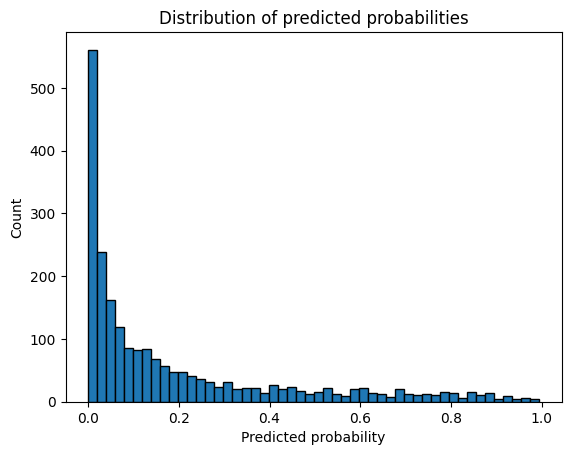

In [ ]:
import matplotlib.pyplot as plt
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

## SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

X_res, y_res = SMOTE(random_state=42).fit_resample(X, y)
print("Balanced class counts:", dict(pd.Series(y_res).value_counts()))

Balanced class counts: {0: np.int64(7888), 1: np.int64(7888)}


In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer # Import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                               recall_score, f1_score, confusion_matrix,
                               classification_report)

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline  # note: imblearn pipeline

# =========================
# 1) Load data
# =========================
CSV_PATH = "test_data.csv"       # <-- adjust if needed
TARGET   = "rehosp7d"           # or rehosp7d/14d/21d etc.

df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# Drop rows with missing target
df = df[df[TARGET].notna()].copy()
y = df[TARGET].astype(int)

# =========================
# 2) Datetime → engineered features (optional but helpful)
# =========================
for c in ["admittime","dischtime","edregtime","edouttime"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]  = s.dt.year
    out[f"{prefix}_month"] = s.dt.month
    out[f"{prefix}_dow"]   = s.dt.dayofweek
    out[f"{prefix}_hour"]  = s.dt.hour
    return out

extra = []
if "admittime" in df.columns:
    extra.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds()/3600.0
    extra.append(pd.DataFrame({"ed_len_hours": ed_len_hours}, index=df.index))

if extra:
    df = pd.concat([df] + extra, axis=1)

# =========================
# 3) Feature set (reduced, safe, interpretable)
#    Use RAW columns; one-hot happens in pipeline.
# =========================
candidate_cols = [
    # numerics / engineered numerics (keep only if present)
    "hosp_los", "ed_len_hours", "prev90d_hosp_sum",
    "admit_year", "age", "disch_hour", "anchor_age", "comorbidity",
    "admit_hour", "prev90d_hosp", "admit_month", "admit_dow",
    "disch_dow", "disch_year", "icu_hx",
    # categoricals (raw)
    "sepsistype", "race", "admission_type",
    # optional flag if you created it upstream
    "dod_nan"
]
available = [c for c in candidate_cols if c in df.columns]
if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
X = df[available].copy()

# =========================
# 4) Train / Test split
# =========================
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Class balance before SMOTE (train split):",
      dict(pd.Series(y_tr).value_counts()))

# =========================
# 5) Preprocess → Impute → SMOTE → XGBoost (in a single pipeline)
#    SMOTE happens AFTER preprocessing and imputation.
# =========================
cat_cols = X_tr.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = X_tr.select_dtypes(include=[np.number, "bool"]).columns.tolist()

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", StandardScaler(), num_cols),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# Add an imputer for numerical features BEFORE SMOTE
imputer = SimpleImputer(strategy='mean')

xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    # start with reasonable defaults; you can tune later
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0
)

# IMPORTANT: SMOTE is placed AFTER preprocessing and BEFORE the model
pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("impute", imputer), # Add imputer here
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

# =========================
# 6) Fit
# =========================
pipe.fit(X_tr, y_tr)

# Show post-SMOTE class counts (by applying only up to 'smote' on training)
# (Optional diagnostic)
Xt_prep = pipe.named_steps["prep"].transform(X_tr)
Xt_imputed = pipe.named_steps["impute"].transform(Xt_prep) # Impute after preprocessing
X_res, y_res = pipe.named_steps["smote"].fit_resample(Xt_imputed, y_tr) # SMOTE on imputed data
print("Class balance after SMOTE (train transformed):",
      dict(pd.Series(y_res).value_counts()))


# =========================
# 7) Evaluate
# =========================
probs = pipe.predict_proba(X_te)[:, 1]
pred05 = (probs >= 0.5).astype(int)

auc = roc_auc_score(y_te, probs)
acc = accuracy_score(y_te, pred05)
prec = precision_score(y_te, pred05)
rec  = recall_score(y_te, pred05)
f1   = f1_score(y_te, pred05)

print(f"\nXGB + SMOTE — Test AUC: {auc:.3f}")
print(f"XGB + SMOTE — Accuracy @0.5: {acc:.3f}")
print(f"XGB + SMOTE — Precision @0.5: {prec:.3f}")
print(f"XGB + SMOTE — Recall @0.5: {rec:.3f}")
print(f"XGB + SMOTE — F1 @0.5: {f1:.3f}")

cm = confusion_matrix(y_te, pred05)
print("\nConfusion matrix @0.5:\n", cm)
print("\nClassification report @0.5:\n",
        classification_report(y_te, pred05, digits=3))

# Also scan thresholds to maximize F1 or balanced accuracy (optional)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
best_t_acc = ts[int(np.argmax(accs))]
best_acc = max(accs)
print(f"\nBest Test Accuracy: {best_acc:.3f} at threshold {best_t_acc:.3f}")

# =========================
# 8) Probability table (top 20 by risk)
# =========================
out = pd.DataFrame({
    "prob_xgb_smote": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_smote", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (XGB + SMOTE):")
print(out.head(20).to_string(index=False))

Class balance before SMOTE (train split): {0: np.int64(5916), 1: np.int64(682)}
Class balance after SMOTE (train transformed): {0: np.int64(5916), 1: np.int64(5916)}

XGB + SMOTE — Test AUC: 0.582
XGB + SMOTE — Accuracy @0.5: 0.895
XGB + SMOTE — Precision @0.5: 0.250
XGB + SMOTE — Recall @0.5: 0.004
XGB + SMOTE — F1 @0.5: 0.009

Confusion matrix @0.5:
 [[1969    3]
 [ 227    1]]

Classification report @0.5:
               precision    recall  f1-score   support

           0      0.897     0.998     0.945      1972
           1      0.250     0.004     0.009       228

    accuracy                          0.895      2200
   macro avg      0.573     0.501     0.477      2200
weighted avg      0.830     0.895     0.848      2200


Best Test Accuracy: 0.896 at threshold 0.439

Top 20 predictions (XGB + SMOTE):
 prob_xgb_smote  true
          0.571     0
          0.548     0
          0.511     0
          0.500     1
          0.479     0
          0.477     1
          0.470     0
    

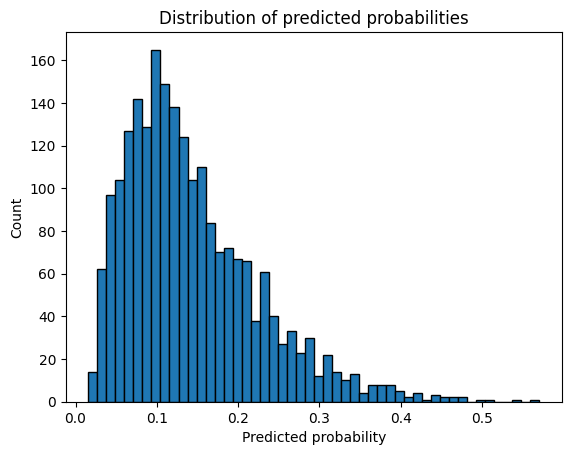

In [ ]:
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

In [ ]:
out

,prob_xgb_smote,true
0,0.571,0
1,0.548,0
2,0.511,0
3,0.500,1
4,0.479,0
...,...,...
2195,0.021,0
2196,0.020,0
2197,0.020,0
2198,0.018,0


## Final Model

In [ ]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import (roc_auc_score, accuracy_score, precision_score,
                               recall_score, f1_score, confusion_matrix,
                               classification_report)

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# =========================
# 1) Load data
# =========================
CSV_PATH = "test_data.csv"       # <-- adjust if needed
TARGET   = "rehosp7d"           # or rehosp7d/14d/21d etc.

df = pd.read_csv(CSV_PATH)

if TARGET not in df.columns:
    raise ValueError(f"Target '{TARGET}' not found. Available: {list(df.columns)}")

# Drop rows with missing target
df = df[df[TARGET].notna()].copy()
y = df[TARGET].astype(int)

# =========================
# 2) Datetime → engineered features (optional but helpful)
# =========================
for c in ["admittime","dischtime","edregtime","edouttime"]:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

def add_dt_feats(prefix, s):
    out = pd.DataFrame(index=s.index)
    out[f"{prefix}_year"]  = s.dt.year
    out[f"{prefix}_month"] = s.dt.month
    out[f"{prefix}_dow"]   = s.dt.dayofweek
    out[f"{prefix}_hour"]  = s.dt.hour
    return out

extra = []
if "admittime" in df.columns:
    extra.append(add_dt_feats("admit", df["admittime"]))
if "dischtime" in df.columns:
    extra.append(add_dt_feats("disch", df["dischtime"]))
if {"edregtime","edouttime"}.issubset(df.columns):
    ed_len_hours = (df["edouttime"] - df["edregtime"]).dt.total_seconds()/3600.0
    extra.append(pd.DataFrame({"ed_len_hours": ed_len_hours}, index=df.index))

if extra:
    df = pd.concat([df] + extra, axis=1)

# =========================
# 3) Feature set (reduced, safe, interpretable)
#    Use RAW columns; one-hot happens in pipeline.
# =========================
candidate_cols = [
   "hosp_los",
   "ed_len_hours",
   "prev90d_hosp_sum",
   "age",
   "comorbidity",
   "prev90d_hosp",
   "sepsistype",
   "icu_hx",
   "admission_type", # Use raw categorical column
   "race", # Use raw categorical column
   "admission_type_DIRECT EMER.", # Keep if already engineered or needed for correlation
   "race_BLACK/CAPE VERDEAN", # Keep if already engineered or needed for correlation
   "admission_type_SURGICAL SAME DAY ADMISSION" # Keep if already engineered or needed for correlation
]

# Filter to only include columns present in the DataFrame
available = [c for c in candidate_cols if c in df.columns]

# For the pipeline, we need the *raw* categorical and numerical columns from the *available* list
raw_cat_cols_for_pipeline = [c for c in available if c in ["admission_type", "race", "sepsistype"]]
raw_num_cols_for_pipeline = [c for c in available if c not in raw_cat_cols_for_pipeline]


if not available:
    raise ValueError("None of the selected reduced features are present in the CSV.")
# Use the full available set for splitting, the pipeline will handle subsetting and transformation
X = df[available].copy()


# =========================
# 4) Train / Test split
# =========================
X_tr, X_te, y_tr, y_te = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print("Class balance before SMOTE (train split):",
      dict(pd.Series(y_tr).value_counts()))

# =========================
# 5) Preprocess → Impute → SMOTE → XGBoost (in a single pipeline)
#    SMOTE happens AFTER preprocessing and imputation.
# =========================
# Define preprocessing steps with imputation for numerical columns
preprocess = ColumnTransformer(
    transformers=[
        # Apply imputation and scaling to numerical columns
        ("num", Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())]), raw_num_cols_for_pipeline),
        # Apply one-hot encoding to categorical columns
        ("cat", OneHotEncoder(handle_unknown="ignore"), raw_cat_cols_for_pipeline),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)


xgb = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
    # start with reasonable defaults; you can tune later
    n_estimators=400,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    min_child_weight=3,
    reg_lambda=1.0
)

# IMPORTANT: SMOTE is placed AFTER preprocessing and BEFORE the model
pipe = ImbPipeline(steps=[
    ("prep", preprocess),
    ("smote", SMOTE(random_state=42)),
    ("model", xgb)
])

# =========================
# 6) Fit
# =========================
pipe.fit(X_tr, y_tr)

# Show post-SMOTE class counts (by applying only up to 'smote' on training)
# (Optional diagnostic)
# Transform training data through preprocessing and imputation before SMOTE
Xt_prep_imputed = pipe.named_steps["prep"].transform(X_tr)
X_res, y_res = pipe.named_steps["smote"].fit_resample(Xt_prep_imputed, y_tr)
print("Class balance after SMOTE (train transformed):",
      dict(pd.Series(y_res).value_counts()))


# =========================
# 7) Evaluate
# =========================
probs = pipe.predict_proba(X_te)[:, 1]
pred05 = (probs >= 0.5).astype(int)

auc = roc_auc_score(y_te, probs)
acc = accuracy_score(y_te, pred05)
prec = precision_score(y_te, pred05)
rec  = recall_score(y_te, pred05)
f1   = f1_score(y_te, pred05)

print(f"\nXGB + SMOTE — Test AUC: {auc:.3f}")
print(f"XGB + SMOTE — Accuracy @0.5: {acc:.3f}")
print(f"XGB + SMOTE — Precision @0.5: {prec:.3f}")
print(f"XGB + SMOTE — Recall @0.5: {rec:.3f}")
print(f"XGB + SMOTE — F1 @0.5: {f1:.3f}")

cm = confusion_matrix(y_te, pred05)
print("\nConfusion matrix @0.5:\n", cm)
print("\nClassification report @0.5:\n",
        classification_report(y_te, pred05, digits=3))

# Also scan thresholds to maximize F1 or balanced accuracy (optional)
ts = np.linspace(0, 1, 1001)
accs = [accuracy_score(y_te, (probs >= t).astype(int)) for t in ts]
best_t_acc = ts[int(np.argmax(accs))]
best_acc = max(accs)
print(f"\nBest Test Accuracy: {best_acc:.3f} at threshold {best_t_acc:.3f}")

# =========================
# 8) Probability table (top 20 by risk)
# =========================
out = pd.DataFrame({
    "prob_xgb_smote": np.round(probs, 3),
    "true": y_te.to_numpy()
}).sort_values("prob_xgb_smote", ascending=False).reset_index(drop=True)

print("\nTop 20 predictions (XGB + SMOTE):")
print(out.head(20).to_string(index=False))

Class balance before SMOTE (train split): {0: np.int64(5916), 1: np.int64(682)}
Class balance after SMOTE (train transformed): {0: np.int64(5916), 1: np.int64(5916)}

XGB + SMOTE — Test AUC: 0.588
XGB + SMOTE — Accuracy @0.5: 0.876
XGB + SMOTE — Precision @0.5: 0.238
XGB + SMOTE — Recall @0.5: 0.088
XGB + SMOTE — F1 @0.5: 0.128

Confusion matrix @0.5:
 [[1908   64]
 [ 208   20]]

Classification report @0.5:
               precision    recall  f1-score   support

           0      0.902     0.968     0.933      1972
           1      0.238     0.088     0.128       228

    accuracy                          0.876      2200
   macro avg      0.570     0.528     0.531      2200
weighted avg      0.833     0.876     0.850      2200


Best Test Accuracy: 0.898 at threshold 0.640

Top 20 predictions (XGB + SMOTE):
 prob_xgb_smote  true
          0.716     1
          0.680     1
          0.672     0
          0.658     1
          0.653     1
          0.649     1
          0.649     0
    

In [ ]:
# BEFORE SMOTE: class counts in the training split
print("y_tr counts (before SMOTE):")
print(y_tr.value_counts())

# Transform X_tr the same way the pipeline does before SMOTE
Xt = pipe.named_steps["prep"].fit_transform(X_tr)   # fit on train only
# Apply the imputer before applying SMOTE
Xt_imputed = pipe.named_steps["impute"].transform(Xt)

sm = pipe.named_steps["smote"]

# Apply SMOTE to get the resampled matrices (for inspection only)
Xt_res, y_res = sm.fit_resample(Xt_imputed, y_tr)

print("\ny_res counts (after SMOTE):")
print(pd.Series(y_res).value_counts())

# How many TOTAL samples were added?
added_total = len(y_res) - len(y_tr)
print(f"\nTotal samples added by SMOTE: {added_total}")

# How many were added per class?
before = y_tr.value_counts().to_dict()
after  = pd.Series(y_res).value_counts().to_dict()
added_per_class = {k: after.get(k,0) - before.get(k,0) for k in set(after)|set(before)}
print("Samples added per class:", added_per_class)

y_tr counts (before SMOTE):
rehosp7d
0    5916
1     682
Name: count, dtype: int64

y_res counts (after SMOTE):
rehosp7d
0    5916
1    5916
Name: count, dtype: int64

Total samples added by SMOTE: 5234
Samples added per class: {0: 0, 1: 5234}


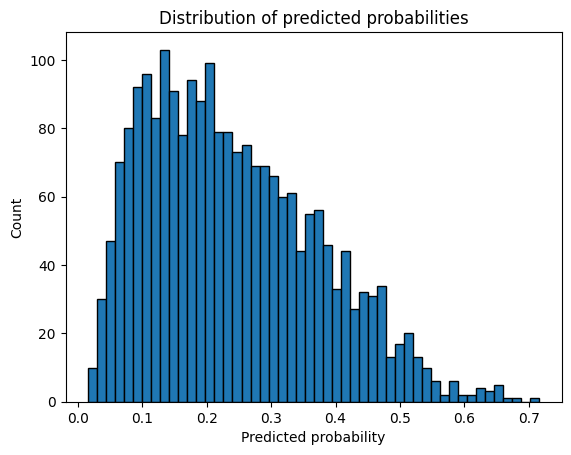

In [ ]:
import matplotlib.pyplot as plt
plt.hist(probs, bins=50, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted probabilities")
plt.show()

In [ ]:
import numpy as np
import pandas as pd

# Set the probability column you want to bucket
PROB_COL = "prob_xgb_smote"   # e.g., "prob_xgb_tuned" or "prob_lr"

# Create risk band + a high-risk flag
out["risk_level"] = np.select(
    [
        out[PROB_COL] > 0.5,
        (out[PROB_COL] >= 0.30) & (out[PROB_COL] <= 0.5),
        out[PROB_COL] < 0.30
    ],
    ["High", "Medium", "Low"],
    default="Low"  # Set the default to a string
)

out["high_risk_flag"] = (out[PROB_COL] > 0.65).astype(int)

# Quick summary
print(out["risk_level"].value_counts().reindex(["High","Medium","Low"]).fillna(0).astype(int))
print("\nPreview:")
print(out[[PROB_COL, "risk_level", "high_risk_flag"]].head(10))

risk_level
High        83
Medium     599
Low       1518
Name: count, dtype: int64

Preview:
   prob_xgb_smote risk_level  high_risk_flag
0           0.716       High               1
1           0.680       High               1
2           0.672       High               1
3           0.658       High               1
4           0.653       High               1
5           0.649       High               0
6           0.649       High               0
7           0.649       High               0
8           0.640       High               0
9           0.639       High               0


In [ ]:
out['risk_level'].value_counts()

,count
risk_level,
Low,1518
Medium,599
High,83


Text(0, 0.5, 'Count')

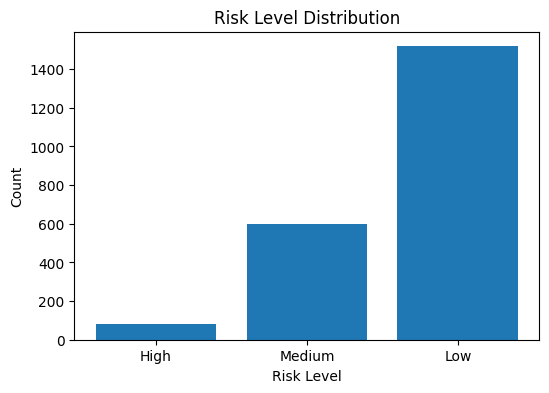

In [ ]:
import matplotlib.pyplot as plt

# Pick the column you created earlier
col = "risk_level"   # or "risk_band"

# Get counts in a nice order
counts = out[col].value_counts().reindex(["High", "Medium", "Low"]).fillna(0)

# Plot
plt.figure(figsize=(6,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Risk Level Distribution")
plt.xlabel("Risk Level")
plt.ylabel("Count")

In [ ]:
df.columns

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag', 'hosp_los',
       'adm_inhosp', 'icd9_sepsiscode', 'icd9_septicshock', 'icd10_sepsiscode',
       'icd10_septicshock', 'icd_version', 'icd9_angus', 'icd10_angus',
       'icd9_angus_over', 'icd10_angus_over', 'icd9_sepsiscode_over',
       'icd10_sepsiscode_over', 'sepsis', 'sepsistype', 'sepsistype_three',
       'anchor_age', 'age', 'gender', 'dod', 'older_adult',
       'discharge_location_factor', 'race_cate', 'race_tetra', 'race_tricho',
       'marital_dichotomous', 'insurance_dicho', 'admission_type_cate',
       'prev90d', 'prev90d_hosp', 'prev90d_hosp_sum', 'icu_hx', 'comorbidity',
       'nextadm30d', 'rehosp30d', 'nextadm7d', 'rehosp7d', 'nextadm30d_date',
       'died30d', 'died30d_noreadm', 'nextadm7d

Correlation matrix (Pearson):
                  hosp_los  ed_len_hours  prev90d_hosp_sum    age  \
hosp_los             1.000        -0.024             0.050 -0.152   
ed_len_hours        -0.024         1.000             0.019  0.004   
prev90d_hosp_sum     0.050         0.019             1.000 -0.100   
age                 -0.152         0.004            -0.100  1.000   
comorbidity          0.092         0.021             0.083  0.024   
rehosp7d             0.054        -0.024             0.135 -0.011   
prev90d_hosp         0.047         0.006             0.785 -0.074   
sepsistype           0.035        -0.038            -0.008 -0.023   
icu_hx               0.163        -0.146            -0.060 -0.053   

                  comorbidity  rehosp7d  prev90d_hosp  sepsistype  icu_hx  
hosp_los                0.092     0.054         0.047       0.035   0.163  
ed_len_hours            0.021    -0.024         0.006      -0.038  -0.146  
prev90d_hosp_sum        0.083     0.135         0.7

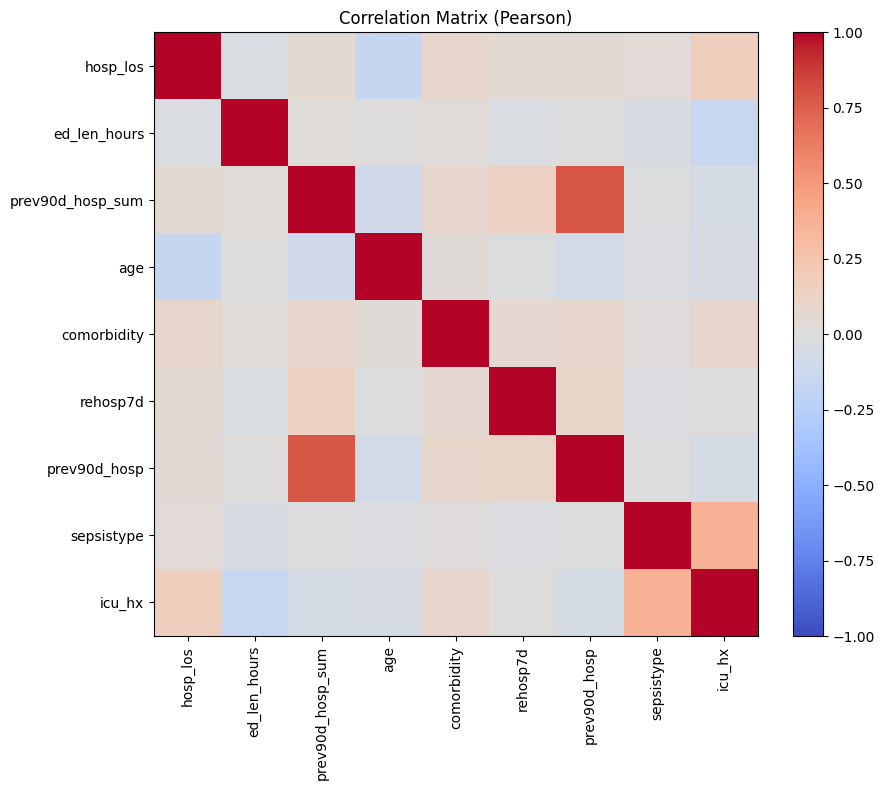

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- your chosen columns (use RAW categorical cols; we’ll one-hot them) ----
selected_features = [
    "hosp_los","ed_len_hours","prev90d_hosp_sum","age","comorbidity", "rehosp7d", "prev90d_hosp",
   "sepsistype",
   "icu_hx",
   "admission_type_DIRECT EMER.",
   "race_BLACK/CAPE VERDEAN",
   "admission_type_SURGICAL SAME DAY ADMISSION"
    ]

# 1) Subset to available columns
feats = [c for c in selected_features if c in df.columns]
df_sel = df[feats].copy()

# 2) Split numeric vs categorical
cat_cols = df_sel.select_dtypes(include=["object","category"]).columns.tolist()
num_cols = [c for c in df_sel.columns if c not in cat_cols]

# 3) Ensure numerics are numeric; impute median for NaNs
df_num = df_sel[num_cols].apply(pd.to_numeric, errors="coerce")
for c in df_num.columns:
    df_num[c] = df_num[c].fillna(df_num[c].median())

# 4) One-hot encode categoricals (include an explicit NaN bucket)
if cat_cols:
    df_cat = pd.get_dummies(
        df_sel[cat_cols].astype("category"),
        dummy_na=True,
        drop_first=False
    )
else:
    df_cat = pd.DataFrame(index=df_sel.index)

# 5) Combine; drop constant columns (correlation undefined for constants)
corr_input = pd.concat([df_num, df_cat], axis=1)
constant_cols = [c for c in corr_input.columns if corr_input[c].nunique(dropna=True) <= 1]
if constant_cols:
    corr_input = corr_input.drop(columns=constant_cols)

# 6) Pearson correlation matrix
corr = corr_input.corr(method="pearson")

# 7) Show as table
print("Correlation matrix (Pearson):")
print(corr.round(3))

# 8) Plot heatmap (Matplotlib)
plt.figure(figsize=(10, 8))
im = plt.imshow(corr.values, vmin=-1, vmax=1, cmap="coolwarm")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Correlation Matrix (Pearson)")
plt.tight_layout()
plt.show()